In [1]:
import os
import cdsapi

import numpy as np
import pandas as pd
import pandas_profiling
import geopandas
import netCDF4
import xarray as xarr # pandas based library for 
            # labeled data with N-D tensors at each dimension
import salem

import matplotlib.pyplot as plt
%matplotlib inline 
import cartopy
import cartopy.crs as ccrs
import seaborn as sns

In [7]:
# This cell needs to be run only once, when the agroclimatic indicators are downloaded from the source

c = cdsapi.Client()

c.retrieve(
    'sis-agroclimatic-indicators',
    {
        'origin': 'era_interim_reanalysis',
        'variable': [
            'biologically_effective_degree_days', 'frost_days', 'heavy_precipitation_days',
            'ice_days', 'maximum_of_daily_maximum_temperature', 'maximum_of_daily_minimum_temperature',
            'mean_of_daily_maximum_temperature', 'mean_of_daily_mean_temperature', 'mean_of_daily_minimum_temperature',
            'mean_of_diurnal_temperature_range', 'minimum_of_daily_maximum_temperature', 'minimum_of_daily_minimum_temperature',
            'precipitation_sum', 'simple_daily_intensity_index', 'summer_days',
            'tropical_nights', 'very_heavy_precipitation_days', 'wet_days',
        ],
        'experiment': 'historical',
        'temporal_aggregation': '10_day',
        'period': '198101_201012',
        'format': 'zip',
    },
    'download.zip')

In [2]:
# Read the data Path where it is stored on the Computer
#data_dir = input('Path to the data\n')
data_dir = os.path.join('C:\\'
                        'Users',
                        'kurt_',
                        'Data',
                        'crop_climotology','')

### Importing the Indicators
<div class="span5 alert alert-info">
Now importing the agroclimatic indicators from the disk where they are stored as a single netcdf file per an indicator. All the files will be merged into a single xarray dataset which will be divided into chunks and parallelization with dask will be enabled to speed up the operations
</div>

In [3]:
# Import data as xarray dataset from the directory
dask = True
if dask:
    # Import with dask
    agroclim = xarr.open_mfdataset(data_dir+'*.nc', parallel=True, 
                              combine='by_coords', chunks={'time': 20}
                             , engine='netcdf4')
    print(f'The chunk size for time dimension is {agroclim.chunks["time"][0]}\n')
    print(f'dataset, thus, have {len(agroclim.time)/agroclim.chunks["time"][0]} chunks')
else:
    # Import without dask for debugging
    agroclim = xarr.open_mfdataset(data_dir+'*.nc', parallel=False, 
                          combine='by_coords', engine='netcdf4')

The chunk size for time dimension is 20

dataset, thus, have 54.0 chunks


### Exploring the indicators dataset

In [4]:
print(agroclim.data_vars)
print(agroclim.coords)
# agroclim

Data variables: (12/19)
    time_bounds  (time, bounds) datetime64[ns] dask.array<chunksize=(20, 2), meta=np.ndarray>
    BEDD         (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    DTR          (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    FD           (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    ID           (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    R10mm        (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    ...           ...
    TNn          (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    TNx          (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    TR           (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    TX           (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarr

agroclim dataset have 2 spatial, one time coordinates and 15 variables. Now let's see what each of these variables are.

In [5]:
for var in agroclim:
    print(f'{var}: {agroclim[var].attrs}')
# Let's select the first time step and plot the 2m-air temperature

# Let's check the dimensions
for dim in agroclim.dims:
    dimsize = agroclim.dims[dim]
    print(f'\nData has {dimsize} {dim} ')
    if dim == 'latitude':
        print(f' latitudes: from {float(agroclim[dim].min())} degree South',
     f'to {float(agroclim[dim].max())} degree North')
    if dim == 'longitude':
        print(f' Longitudes: from {float(agroclim[dim].max())} degree East',
     f'to {float(agroclim[dim].min())} degree West')
    if dim == 'time':
        print(f'time: from {pd.to_datetime(agroclim["time"].min().values)} to {pd.to_datetime(agroclim["time"].max().values)} ')

time_bounds: {}
BEDD: {'units': 'degrees_C', 'long_name': 'Biologically Effective Degree Days', 'cell_methods': 'time: sum'}
DTR: {'units': '', 'long_name': 'Mean of diurnal temperature range', 'cell_methods': 'time: mean'}
FD: {'units': 'day', 'long_name': 'Frost days (minimum temperature < 0 degrees_C)', 'cell_methods': 'time: sum'}
ID: {'units': 'day', 'long_name': 'Ice days (maximum temperature < 0 degrees_C)', 'cell_methods': 'time: sum'}
R10mm: {'units': 'day', 'long_name': 'Heavy precipitation days (precipitation >= 10 mm)', 'cell_methods': 'time: sum'}
R20mm: {'units': 'day', 'long_name': 'Very heavy precipitation days (precipitation >= 20 mm)', 'cell_methods': 'time: sum'}
RR: {'units': 'mm', 'long_name': 'Precipitation sum', 'cell_methods': 'time: sum'}
RR1: {'units': 'day', 'long_name': 'Wet days (precipitation >= 1 mm)', 'cell_methods': 'time: sum'}
SDII: {'units': 'mm', 'long_name': 'Simple daily intensity index for wet days (mm/wet day)', 'cell_methods': 'time: mean'}
SU:

# Preparing The Crop Production Data
Crop Data is obtained from:


### Alfalfa Hay
Alfalfa hay is produced mostly in North-Western States. Among them it is produced throughout all Montana and in most of the Idaho which makes them more convenient for agroclimatic analysis.

Here is the map that shows where Alfala hay is produced
Source: https://www.nass.usda.gov/Charts_and_Maps/Crops_County/al-ha.php

* Masking climate data only to keep the relavant states using **Salem**
* Geospatial data for the state boundaries are from US Census
* Let's examine the shape file for US States using __Geopandas__


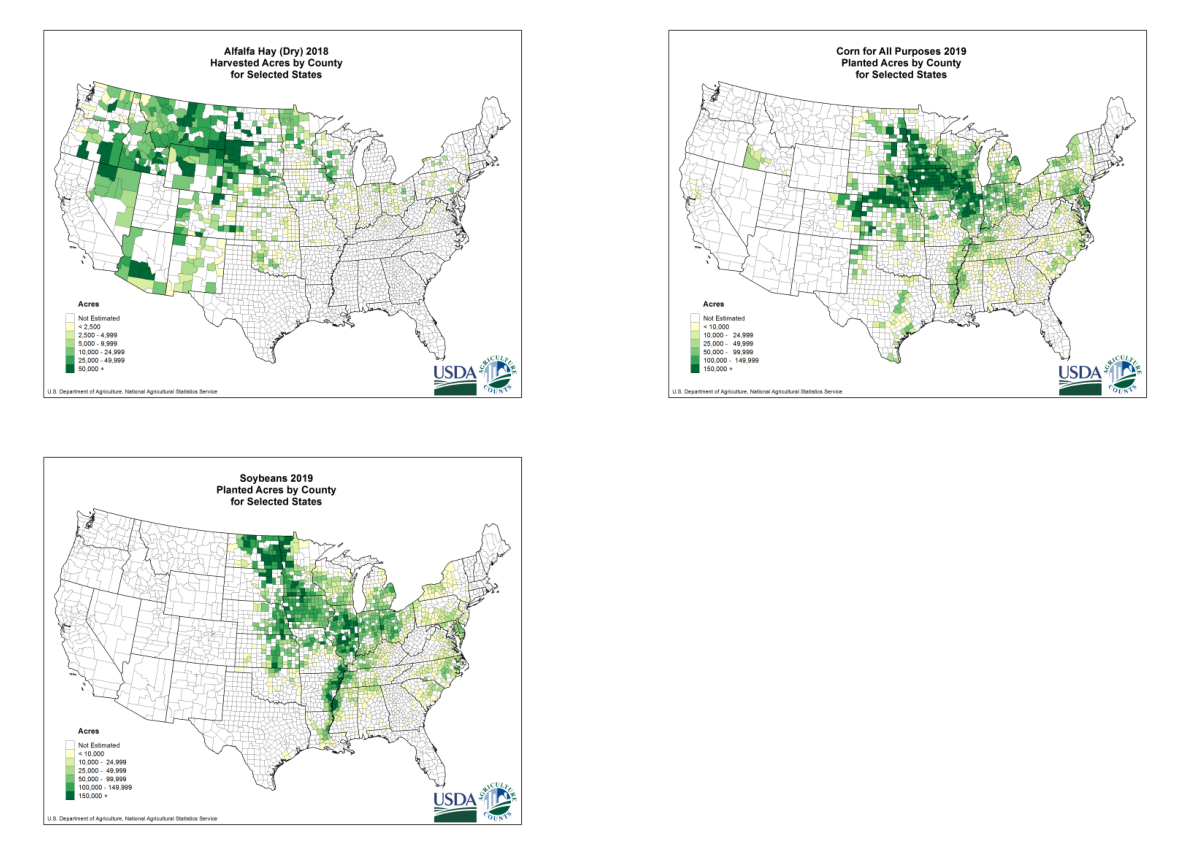

In [6]:

from matplotlib.gridspec import GridSpec
import matplotlib as mpl

mpl.rc('figure', figsize = (18,12))
fig = plt.figure()
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

a = plt.imread("https://www.nass.usda.gov/Charts_and_Maps/graphics/AL-HA-RGBChor.png")
ax1.imshow(a)
c = plt.imread("https://www.nass.usda.gov/Charts_and_Maps/graphics/CR-PL-RGBChor.png")
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(c)
s = plt.imread("https://www.nass.usda.gov/Charts_and_Maps/graphics/SB-PL-RGBChor.png")
ax3 = fig.add_subplot(gs[1, 0])
ax3.imshow(s)
for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
plt.tight_layout()
plt.show()
plt.close()

mpl.rcParams.update(mpl.rcParamsDefault)

## Embedding Geospatial Coordinates For Statewise operations

In [7]:
# Let's read the geospatial data for the states
path_geo = 'C:\\Users\\kurt_\\Data\\usstates\\'
geo_usa = geopandas.read_file(path_geo)
print(type(geo_usa))
print('The coordinate Reference System Info:')
print(geo_usa.crs)
geo_usa.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
The coordinate Reference System Info:
epsg:4269


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


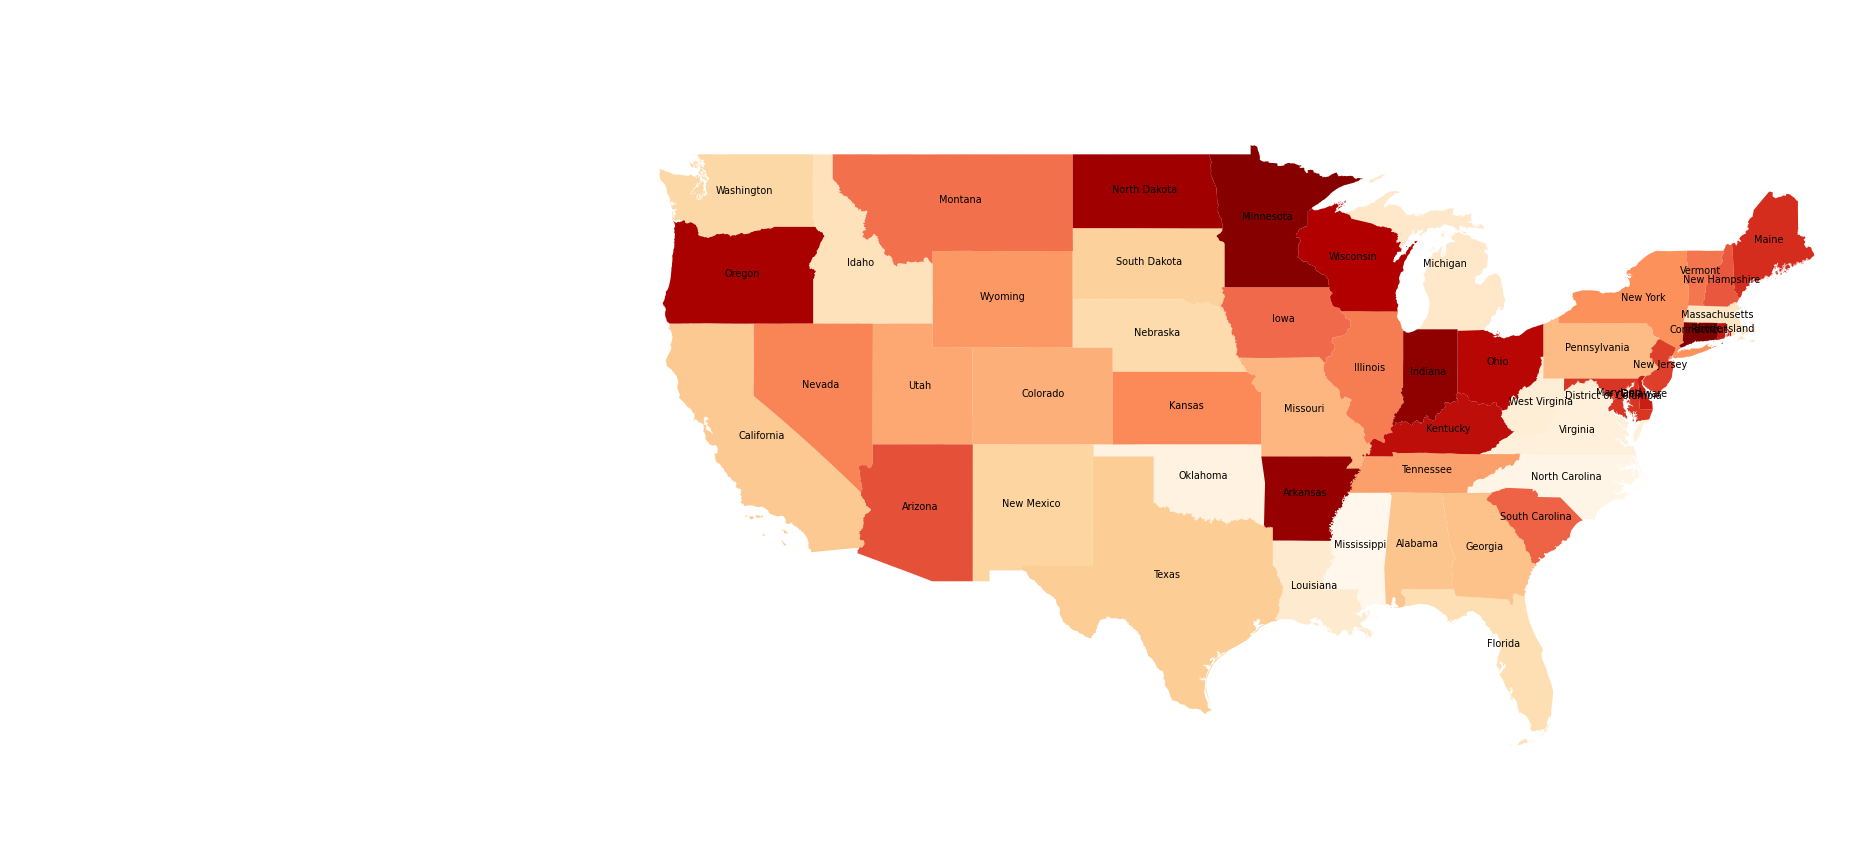

In [8]:
# Let's see the state boundaries on a map to see
# if there is an error

# Getting rid of oversees territories from the map
geo_usa = geo_usa[geo_usa.STATEFP.apply(lambda x: int(x)) < 60]
#Let's remove the Alaska too
geo_usa = geo_usa[geo_usa.NAME != 'Alaska']
fig,ax = plt.subplots(figsize=(16, 12))
geo_usa.plot(ax=ax, cmap='OrRd')
ax.set_xlim(-127,-65)
ax.set_ylim(22,55)
ax.set_yticks([])
ax.set_xticks([])
ax.axis("off")
geo_usa.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7),axis=1);
#plt.tight_layout()
plt.show()
plt.close()

<div class="span5 alert alert-info">
We will now embedd the geogrophical coordinates data of the states to our climate data. Then we will plot 2-d temperature variable of two states on a random day to make sure that everything is fine.
</div>

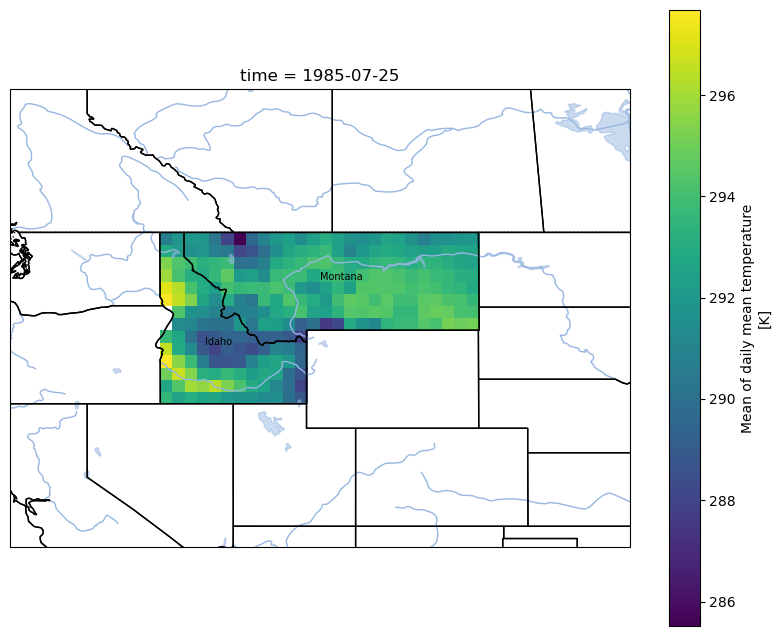

In [9]:
# Plotting a random time step just to see the data on a map
alfala_states = ['Montana', 'Idaho']

fig = plt.figure(figsize=(10, 8))

# plotting on a map using cartopy
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.STATES)

# plotting using xarray plot method
# Montana and Idaho For Alfala Barley
MT_coord = salem.read_shapefile(path_geo+'cb_2018_us_state_500k.shp')
MT_coord = MT_coord[(MT_coord.NAME.isin(alfala_states))]

# Extracting only the region of interest from climate data
mnt_sub = agroclim.salem.subset(shape=MT_coord, margin=10)
MT_coord.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7),axis=1);

# Let's plot the daily average tempreture on a random time
randm_day = mnt_sub['TG'].isel( time=np.random.randint(len(mnt_sub.time)))
randm_day.salem.roi(shape=MT_coord).plot(ax=ax)
#Montana_anm = clim_loc['TG'].isel( time=np.random.randint(len(clim_loc.time))) - clim_loc['TG'].mean(dim='time')
#Montana_anm.plot(ax=ax)
plt.show()
plt.close()

## Preparing Crop Production Data
Data link: https://quickstats.nass.usda.gov/results/347988B6-8746-305D-9147-D1A31FE09FD2

<div class="span5 alert alert-info">
It's time get our crop production data which contain various fields. The most important fields for this work are the State, Commodity, and the yield (Value). However, we do not need all the eentries as some of them are irrelevant for our purpose or using them make it too complex for the scope of this work. Therefore, we will use most of the columns, even if we wouldn't need them eventually, to filter out those entries we want to get rid of.
</div>

In [10]:
#  Now Reading All the Crop Data that we are interested in to a dataframe
path = "Data/"
# Let's read and merge all the crops data into a single dataframe
# This way data wrangling steps will be less cumbersome
files = [path+"Alfala.csv", path+"Corn.csv", path+"Soybean.csv"]
df = (pd.read_csv(f) for f in files)
df_crop = pd.concat(df, ignore_index=True)
df_crop.head(3).T

,0,1,2
Program,SURVEY,SURVEY,SURVEY
Year,2019,2019,2019
Period,YEAR,YEAR,YEAR
Week Ending,NaN,NaN,NaN
Geo Level,STATE,STATE,STATE
State,IDAHO,IDAHO,MONTANA
State ANSI,16,16,30
Ag District,NaN,NaN,NaN
Ag District Code,NaN,NaN,NaN
County,NaN,NaN,NaN


In [11]:
df_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8522 entries, 0 to 8521
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Program           8522 non-null   object 
 1   Year              8522 non-null   int64  
 2   Period            8522 non-null   object 
 3   Week Ending       0 non-null      float64
 4   Geo Level         8522 non-null   object 
 5   State             8522 non-null   object 
 6   State ANSI        8522 non-null   int64  
 7   Ag District       0 non-null      float64
 8   Ag District Code  0 non-null      float64
 9   County            0 non-null      float64
 10  County ANSI       0 non-null      float64
 11  Zip Code          0 non-null      float64
 12  Region            0 non-null      float64
 13  watershed_code    8522 non-null   int64  
 14  Watershed         0 non-null      float64
 15  Commodity         8522 non-null   object 
 16  Data Item         8522 non-null   object 


We are not interested in most of these columns. The only relevant columns are these: `State`, `State ANSI` (may be helpful for a regression model), `Commodity`, `Data Item`(that is the column associated with the Value column along with State colums), `Domain`, `Value` (This is what we are trying to predict). However, we might need to check them first to decide which rows to include for our model. 

* **Value column is object type. We need to convert it to Float.**
* Also Let's drop all other nan values. None of the columns we are interested in has any nan values.


In [12]:
f = lambda x: x.replace(',', '')
df_crop['Value'] = df_crop['Value'].apply(f)
# Before converting to numeric let's see if there is non-numeric values and what they are
def IsNumeric(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
S = lambda s: isinstance(s, (int, float))
_isdigit = df_crop['Value'].apply(IsNumeric)
_r = df_crop[~_isdigit]['Value'].value_counts()
print(f'There are {_r[0]} entries with the value of "{_r.index[0]}"' )

There are 156 entries with the value of " (D)"


**According to the [Quick Stats Glossary](https://quickstats.nass.usda.gov/src/glossary.pdf) published by USDA for this dataset "D" corresponds to:** 

> **Withheld to avoid disclosing data for individual operations.**

Thus all we can do is dropping these rows.


In [13]:
df_crop['Value'] = pd.to_numeric(df_crop['Value'], errors='coerce')
df_crop['Value'].isnull().sum()

156

Now Let's drop all nan values together. Let's first check the with null values in the dataframe

In [14]:
# Missing Values
nan=pd.DataFrame(df_crop.isnull().sum().sort_values(ascending=False), columns = ['NULL values'])
nan.query('`NULL values` > 0').T

,County ANSI,Ag District Code,Watershed,Week Ending,Region,Zip Code,County,Ag District,CV (%),Value
NULL values,8522,8522,8522,8522,8522,8522,8522,8522,7561,156


In [15]:
#first get rid of the nan values in Value column only
df_crop.dropna(subset=['Value'], inplace=True)
# Now we can drop all the columns with nan values at once
df_crop.dropna(axis=1, inplace=True)
# Fixing the index
df_crop.reset_index(drop=True, inplace=True)
print(df_crop.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8366 entries, 0 to 8365
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Program          8366 non-null   object 
 1   Year             8366 non-null   int64  
 2   Period           8366 non-null   object 
 3   Geo Level        8366 non-null   object 
 4   State            8366 non-null   object 
 5   State ANSI       8366 non-null   int64  
 6   watershed_code   8366 non-null   int64  
 7   Commodity        8366 non-null   object 
 8   Data Item        8366 non-null   object 
 9   Domain           8366 non-null   object 
 10  Domain Category  8366 non-null   object 
 11  Value            8366 non-null   float64
dtypes: float64(1), int64(3), object(8)
memory usage: 784.4+ KB
None


**There are some constant values and some entries we are not interested in. Let's remove them from the df_crop**

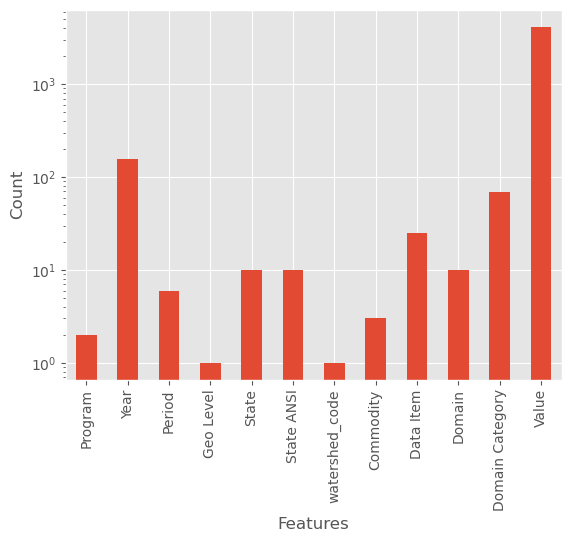

In [16]:
# First let's take a look at the number of unique 
# values in each column in a bar plot
plt.style.use('ggplot')
df_crop.nunique().plot(kind='bar', logy=True)
plt.xlabel('Features')
plt.ylabel('Count')
plt.show()
plt.close()
# Find those columns with constant values

**We need only Year entries for Period. Let's see what else is in there**

In [17]:
df_crop['Period'].value_counts()

YEAR                   6112
YEAR - AUG FORECAST     637
YEAR - OCT FORECAST     564
YEAR - SEP FORECAST     502
YEAR - NOV FORECAST     479
YEAR - JUN ACREAGE       72
Name: Period, dtype: int64

Looks like some values are just forecast entries not observations. We don't need any of those.

In [18]:
# dropping all rows with forecast entries given in Period column
mask_year = df_crop['Period'] == 'YEAR'
df_crop = df_crop[mask_year]
df_crop.reset_index(drop=True, inplace=True)
df_crop.nunique()

Program               2
Year                155
Period                1
Geo Level             1
State                10
State ANSI           10
watershed_code        1
Commodity             3
Data Item            25
Domain               10
Domain Category      69
Value              3937
dtype: int64

**Let's take a look at the Domain Catogories.**
* For this study some of the domains are irrelavant, like "ECONOMIC CLASS"
* Domain Catogories should be consistent among all "Data Item" values

In [19]:
print(df_crop['Domain Category'].nunique())
df_crop['Domain Category'].value_counts().head(10)

69


NOT SPECIFIED                             4993
AREA HARVESTED: (250 TO 499 ACRES)          40
AREA HARVESTED: (500 TO 999 ACRES)          40
AREA HARVESTED: (100 TO 249 ACRES)          39
AREA HARVESTED: (1,000 OR MORE ACRES)       39
AREA HARVESTED: (50.0 TO 99.9 ACRES)        38
AREA HARVESTED: (25.0 TO 49.9 ACRES)        36
AREA HARVESTED: (1.0 TO 14.9 ACRES)         36
AREA HARVESTED: (1,000 TO 1,999 ACRES)      35
AREA HARVESTED: (15.0 TO 24.9 ACRES)        34
Name: Domain Category, dtype: int64

We have two sources of records which are given in the `Program` field. Let's check these resources.

In [20]:
df_crop['Program'].value_counts()

SURVEY    4929
CENSUS    1183
Name: Program, dtype: int64

In [21]:
mask_DomCat = df_crop['Domain Category'] != 'NOT SPECIFIED'
print(df_crop[mask_DomCat].Commodity.value_counts())
print(df_crop[mask_DomCat].Program.value_counts())
df_crop[mask_DomCat]['Domain Category'].value_counts()

SOYBEANS    1119
Name: Commodity, dtype: int64
CENSUS    1119
Name: Program, dtype: int64


AREA HARVESTED: (250 TO 499 ACRES)       40
AREA HARVESTED: (500 TO 999 ACRES)       40
AREA HARVESTED: (1,000 OR MORE ACRES)    39
AREA HARVESTED: (100 TO 249 ACRES)       39
AREA HARVESTED: (50.0 TO 99.9 ACRES)     38
                                         ..
WATER SOURCE: (ON FARM SURFACE)           7
NAICS CLASSIFICATION: (1124)              7
WATER SOURCE: (OFF FARM)                  6
NAICS CLASSIFICATION: (1113)              6
NAICS CLASSIFICATION: (11191)             1
Name: Domain Category, Length: 68, dtype: int64

There are 69 Domain Categories, but only Soybeans from CENSUS have Categories other than `NOT SPECIFIED`.
**Hence, for now I seperate all those Domain Categories to deal with them later since they require special handling.**

Note that these entries are from CENCUS records. Thus it is already more reasonable not to mix data from two different source **("Survey and Cencus")**

In [22]:
# creating new dataframe for soybeans from CENSUS
df_soybean_census = df_crop[mask_DomCat]

In [23]:
# Crerating a new dataframe for Survey only crops
df_crop_srv = df_crop[~mask_DomCat]

In [24]:
# Let's see what commodities left in the df_crop_srv
df_crop_srv.Commodity.value_counts()

CORN        2685
HAY         1504
SOYBEANS     804
Name: Commodity, dtype: int64

In [25]:
df_crop_srv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993 entries, 0 to 6111
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Program          4993 non-null   object 
 1   Year             4993 non-null   int64  
 2   Period           4993 non-null   object 
 3   Geo Level        4993 non-null   object 
 4   State            4993 non-null   object 
 5   State ANSI       4993 non-null   int64  
 6   watershed_code   4993 non-null   int64  
 7   Commodity        4993 non-null   object 
 8   Data Item        4993 non-null   object 
 9   Domain           4993 non-null   object 
 10  Domain Category  4993 non-null   object 
 11  Value            4993 non-null   float64
dtypes: float64(1), int64(3), object(8)
memory usage: 507.1+ KB


We are only interested some of these columns. Let's drop the ones we will not use.

**We do not need constant value columns**

In [26]:
# Getting rid of the columns with constant values
nunq = df_crop_srv.nunique()
dropped = []
for clm in df_crop_srv:
    if nunq.loc[clm] == 1:
        df_crop_srv = df_crop_srv.drop(clm, axis=1)
        dropped.append(clm)
print(df_crop_srv.nunique(),'\n\n')
print(f'dropped columns: {dropped}')

Program          2
Year           155
State           10
State ANSI      10
Commodity        3
Data Item       21
Value         2960
dtype: int64 


dropped columns: ['Period', 'Geo Level', 'watershed_code', 'Domain', 'Domain Category']


In [27]:
# Now fixing the index
df_crop_srv = df_crop_srv.reset_index(drop=True)

In [28]:
df_crop_srv.sample(3)

,Program,Year,State,State ANSI,Commodity,Data Item,Value
1126,SURVEY,1963,WYOMING,56,HAY,"HAY, ALFALFA, NON-IRRIGATED - PRODUCTION, MEAS...",1.331000e+05
3212,SURVEY,1931,WISCONSIN,55,CORN,"CORN, GRAIN - PRODUCTION, MEASURED IN BU",2.177900e+07
1624,SURVEY,2014,NEBRASKA,31,CORN,"CORN, GRAIN - PRODUCTION, MEASURED IN BU",1.602050e+09


In [29]:
# # Let's get rid of the rows where Period is smth other than Year
# period_to_rid = set(hay['Period']).difference(['YEAR'])
# print(f'The following period entries will be removed:\n {period_to_rid}')
# Period_rows = hay['Period'].isin(period_to_rid)
# hay = hay[~Period_rows]
# hay['Period'].value_counts()

## Pre-Processing & Exploring
Now that we have crop data ready for analysis, we should now prepare the climate data. 
* Climate variables should be averaged for each state
* Then we need to aggregate all climate features thorugh each year.
    * Some features require averging, such as mean temperature, some require to be summed such as 'Biologically Effective Degree Days'
    * Note that each feature in climate data can have completely different effect depending on the season or month. For example while frost days can have a devastating effect on April it might have no effect at all on January. Therefore for some climate variables I should treat each month as a separate feature. 
    

## Getting State Climate Data


In [30]:
df_crop_srv['Data Item'].value_counts()

CORN, GRAIN - PRODUCTION, MEASURED IN BU                             775
CORN, GRAIN - YIELD, MEASURED IN BU / ACRE                           775
CORN, GRAIN - ACRES HARVESTED                                        775
HAY, ALFALFA - PRODUCTION, MEASURED IN TONS                          404
HAY, ALFALFA - YIELD, MEASURED IN TONS / ACRE                        404
SOYBEANS - ACRES HARVESTED                                           390
SOYBEANS - YIELD, MEASURED IN BU / ACRE                              370
HAY, ALFALFA, NON-IRRIGATED - PRODUCTION, MEASURED IN TONS           116
HAY, ALFALFA, IRRIGATED - YIELD, MEASURED IN TONS / ACRE             116
HAY, ALFALFA, NON-IRRIGATED - ACRES HARVESTED                        116
HAY, ALFALFA, IRRIGATED - ACRES HARVESTED                            116
HAY, ALFALFA, NON-IRRIGATED - YIELD, MEASURED IN TONS / ACRE         116
HAY, ALFALFA, IRRIGATED - PRODUCTION, MEASURED IN TONS               116
CORN, GRAIN, IRRIGATED - ACRES HARVESTED           

In [31]:
def crop_trend_plot(crop, method=False):
    """method is given when only certain quantities are needed.
    It should be a keyword or keywords which can be used to filter only
    intended quantity(or quantities). e.g. method='YIELD' will 
    only plot Yield in any Unit available.
    Multiple keywords should be separated with space  """
    # creating a list of 
    meas = ["PRODUCTION, MEASURED IN TONS", "PRODUCTION, MEASURED IN BU",
            "YIELD, MEASURED IN TONS / ACRE", "YIELD, MEASURED IN BU / ACRE",
            "ACRES HARVESTED"]
    if method:
        ls = []
        for item in meas:
            if method in item:
                ls.append(item)
        meas = ls
    # SOYBEANS from census were removed, and SURVEY records do not have all the Data Item values as the others
    if crop != 'SOYBEANS':
        crop_type = [" - ",", IRRIGATED - ", ", NON-IRRIGATED - ", ", ORGANIC - "]
    elif crop == 'SOYBEANS':
        crop_type = [" - "]
    
    dt_type = [i+j for i in crop_type for j in meas]
    plotting = [crop+x for x in dt_type]
    for dt in plotting:
        alf_prd = df_crop[df_crop['Data Item'] == dt]
        # plot only if alf_prd has at least one entry
        if len(alf_prd):
            sns.lineplot(data = alf_prd, x='Year', y='Value', hue='State')
            plt.title(dt, fontsize=10)
            plt.show()
            plt.close()
        # elif len(alf_prd) == 0:
        #     print(f"{dt} NOT Exist")

## Alfalfa Hay

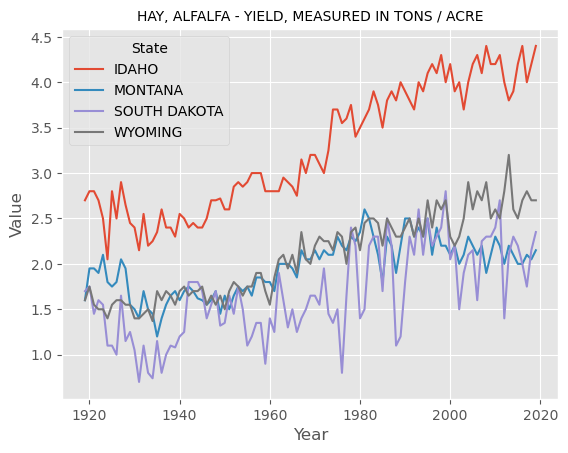

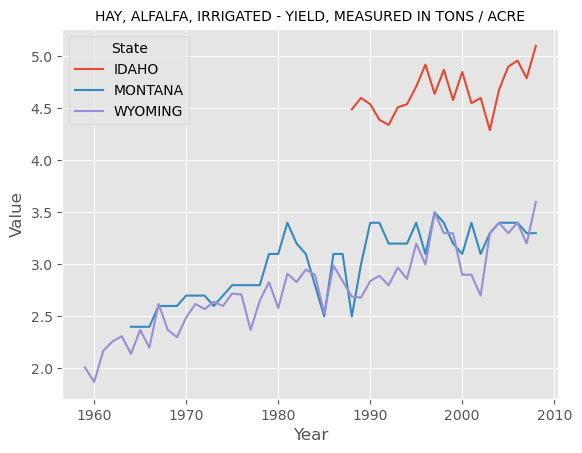

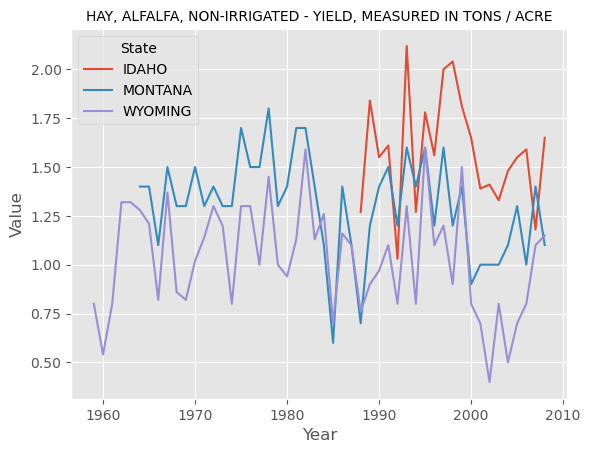

In [32]:
crop_trend_plot("HAY, ALFALFA", method='YIELD')

## Corn Grain

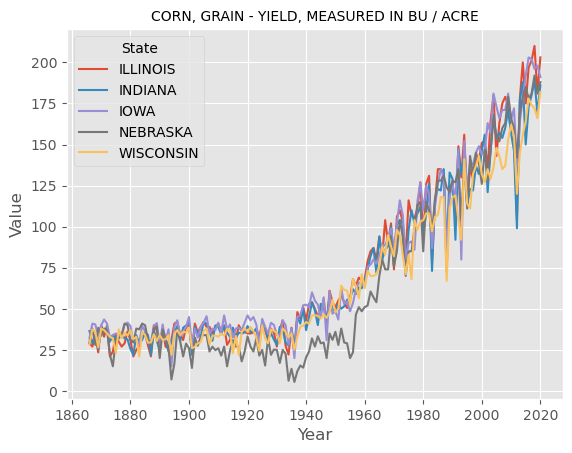

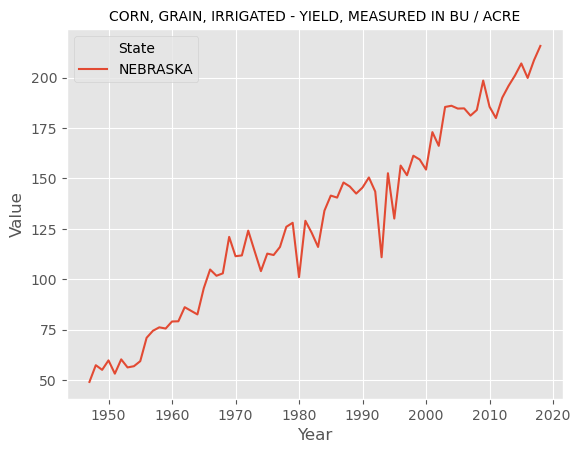

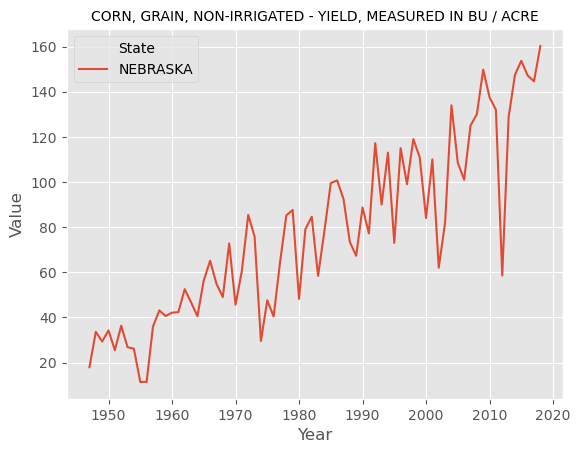

In [39]:
crop_trend_plot("CORN, GRAIN", 'YIELD')

* Corn grain irrigated has less variance comparing to non-irrigated. This might be because irrigation helps the crops much better tolerate any warm and dry growing season

## Soybeans

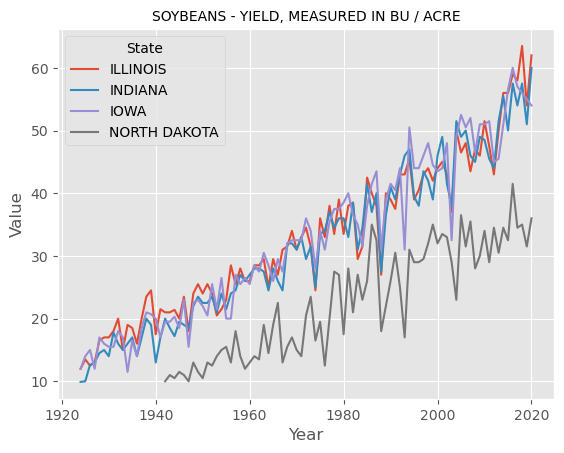

In [40]:
crop_trend_plot("SOYBEANS", 'YIELD')

## Dealing with Trends for Alfala
* There is a clear trend in Alfala production and yield except for Non-Irrigated Alfala
* Significant trend in Alfala is perhaps related to development in agricultral technologies
* Warming climate may also have a positive impact. Irrigated crops might benefit from warmer temperature due to increased photosynthesis. (** REF. **)
* Non-Irrigated crops may or may not tolarate warmer climate depending on soil water availability and some other factors. This would explain the difference between Irrigated and Non-irrigated Alfala yield trends. 
* **The priority of this project is to investigate how crop yield is affected by weather conditions. Therefore interannual variability in yield is more important for this work than decadal variability where the latter is related not only Climate but also development in agricultural technologies and human beheviours.**

* Therofore, I will first **detrend the predictor (climate) variables and response (yield).**  

In [41]:
a= "SOYBEANS, IRRIGATED - ACRES HARVESTED"
ah = "ACRES HARVESTED"
S = lambda s: ah in s
test = df_crop['Data Item'].apply(S)
df_crop[test].head(3)

,Program,Year,Period,Geo Level,State,State ANSI,watershed_code,Commodity,Data Item,Domain,Domain Category,Value
90,SURVEY,2008,YEAR,STATE,IDAHO,16,0,HAY,"HAY, ALFALFA, IRRIGATED - ACRES HARVESTED",TOTAL,NOT SPECIFIED,900000.0
93,SURVEY,2008,YEAR,STATE,IDAHO,16,0,HAY,"HAY, ALFALFA, NON-IRRIGATED - ACRES HARVESTED",TOTAL,NOT SPECIFIED,230000.0
98,SURVEY,2008,YEAR,STATE,MONTANA,30,0,HAY,"HAY, ALFALFA, IRRIGATED - ACRES HARVESTED",TOTAL,NOT SPECIFIED,595000.0


## Getting Climate For Product Zone

Some variables are aggregated as sum of all the occurence 
during default time interval (10 days), while some are averaged
or their extreme value is recorded. The aggregation method is
recorded in "cell_methods" attribute of the variable. Using cell_methods
for each variable monthly aggregations will be calculated. 

Then, All the climate parameters will be spatially averaged through the state level.



In [44]:
agroclim.

<xarray.Dataset>
Dimensions:      (bounds: 2, lat: 360, lon: 720, time: 1080)
Coordinates:
  * time         (time) datetime64[ns] 1981-01-05 1981-01-15 ... 2010-12-25
  * lat          (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon          (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Dimensions without coordinates: bounds
Data variables: (12/19)
    time_bounds  (time, bounds) datetime64[ns] dask.array<chunksize=(20, 2), meta=np.ndarray>
    BEDD         (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    DTR          (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    FD           (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    ID           (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    R10mm        (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    ...           ...
    TNn          (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    TNx          (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    TR           (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    TX           (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    TXn          (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
    TXx          (time, lat, lon) float32 dask.array<chunksize=(20, 360, 720), meta=np.ndarray>
Attributes: (12/14)
    title:          BEDD index from ECA heat indices
    institution:    Copernicus Climate Change Service
    comment:        
    history:         \n2019-04-26 13:25:29 Calculation of BEDD indice (dekada...
    summary:        
    Conventions:    CF-1.7
    ...             ...
    creation_date:  2019-04-26T13:25:29GMT
    lineage:        
    keywords:       
    license:        
    references:     Tank, A.K., 2010. European Climate Assessment and Dataset...
    source:         The WFDEI meteorological forcing data set: WATCH Forcing ...

In [48]:
agroclim_resample = agroclim.resample(time="QS-DEC", keep_attrs=True)

dt_arrays_to_merge = []
for var in agroclim:
    if var == "time_bounds":
        print("skip", var)
        continue
    print(var, agroclim[var].cell_methods)
    if "mean" in agroclim[var].cell_methods:
        vars()[var] = agroclim_resample.mean()[var]
    elif "maximum" in agroclim[var].cell_methods:
        vars()[var] = agroclim_resample.max()[var]
    elif "minimum" in agroclim[var].cell_methods:
        vars()[var] = agroclim_resample.min()[var]
    elif "sum" in agroclim[var].cell_methods:
        vars()[var] = agroclim_resample.sum()[var]
    dt_arrays_to_merge.append(eval(var))
agroclim_monthly = xarr.merge(dt_arrays_to_merge)
agroclim_monthly

skip time_bounds
BEDD time: sum
DTR time: mean
FD time: sum
ID time: sum
R10mm time: sum
R20mm time: sum
RR time: sum
RR1 time: sum
SDII time: mean
SU time: sum
TG time: mean
TN time: mean
TNn time: minimum
TNx time: maximum
TR time: sum
TX time: mean
TXn time: minimum
TXx time: maximum


<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 121)
Coordinates:
  * time     (time) datetime64[ns] 1980-12-01 1981-03-01 ... 2010-12-01
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Data variables: (12/18)
    BEDD     (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    DTR      (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    FD       (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    ID       (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    R10mm    (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    R20mm    (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    ...       ...
    TNn      (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    TNx      (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    TR       (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    TX       (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    TXn      (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    TXx      (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>

In [ ]:
# # First resampling entire dataset. Later individual variables will be resampled 
# # based on their cell_method
# climate = agroclim.resample(time="QS-DEC", keep_attrs=True).sum()
# # Determining cell_method
# for var in climate:
#     rsmpl = dict()
#     # Some variables, such as time_bounds, does not have cell_methods attribute
#     # Don't raise error for those, just skip.
#     # collecting all variables' resampled data in a dict or such would make a 
#     # large single object. I could use chunks but why not keep them as
#     # variable with their unique name
#     try:
#         # variables need to be summed already aggregated as sum
# #         if "mean" in agroclim[var].cell_methods:
# #             vars()[var] = agroclim[var].resample(time="1MS",keep_attrs=True).mean()
#         if "maximum" in agroclim[var].cell_methods:
#             vars()[var] = agroclim[var].resample(time="1MS",keep_attrs=True).max()
# #         elif "minimum" in agroclim[var].cell_methods:
# #             vars()[var] = agroclim[var].resample(time="1MS",keep_attrs=True).min()
#     except:
#         pass

# # Now let's correct resampling of each variables
# for x in agroclim:
#     try:
#         eval(x)
#     except NameError:
#         continue
#     climate[x] = eval(x)
# # free up some memory
# #del agroclim

In [ ]:
climate.dims

## Calculating the climotological state means 

In [ ]:
plt.style.use('seaborn-colorblind')
crop_states = ['Wisconsin'] #list(df_crop.State.unique())
crop_states = [x.title() for x in crop_states]
fig = plt.figure(figsize=(12,10))
# plotting on a map using cartopy
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.STATES)

# plotting using xarray plot method
# Reading state shape files from 
us_states = salem.read_shapefile(path_geo+'cb_2018_us_state_500k.shp')
state_coord = us_states[(us_states.NAME.isin(crop_states))]
# Extracting only the region of interest from climate data
state_clim = climate.salem.subset(shape=state_coord, margin=5)
state_coord.apply(lambda x: ax.annotate(s=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7),axis=1);
# Let's plot the daily average tempreture on a random time
randm_day = state_clim['TG'].isel( time=np.random.randint(len(state_clim.time)))
# randm_day.salem.roi(shape=state_coord).plot(ax=ax)
randm_day = randm_day.salem.roi(shape=state_coord)
plt.pcolormesh(randm_day.lon, randm_day.lat, randm_day)
cb = plt.colorbar(shrink=0.4) # use shrink to make colorbar smaller
cb.set_label(f"{agroclim['DTR'].long_name} in {agroclim['TG'].units}")
plt.title(randm_day.time.values)
plt.show()
plt.close()

In [ ]:
for var in agroclim:
    print(f'{var}: {agroclim[var].attrs}')
# Let's select the first time step and plot the 2m-air temperature

# Let's check the dimensions
for dim in agroclim.dims:
    dimsize = agroclim.dims[dim]
    print(f'\nData has {dimsize} {dim} ')
    if dim == 'latitude':
        print(f' latitudes: from {float(agroclim[dim].min())} degree South',
     f'to {float(agroclim[dim].max())} degree North')
    if dim == 'longitude':
        print(f' Longitudes: from {float(agroclim[dim].max())} degree East',
     f'to {float(agroclim[dim].min())} degree West')
    if dim == 'time':
        print(f'time: from {pd.to_datetime(agroclim["time"].min().values)} to {pd.to_datetime(agroclim["time"].max().values)} ')

Let's write a function for plotting only a certain month in each year. We will use each month group as a single feature

In [72]:
plt.style.use('default')
def plot_month_group(var, *months_to_plot ):
    #plt.style.use('seaborn-paper')
    # plt.style.use('tableau-colorblind10')
    plt.style.use([ 'tableau-colorblind10'])
    # 
    """ var is the variable to plot in the dataset. It should be given as a string
    months_to_plot should be an integer corresponding to a month. 
    Multiple months should be separated with commas. 
    e.g. plot_month_group('TXn',12,1,2) 

    """
    
    for mon in state_clim[var].groupby("time.month"):
        if mon[1]['time.month'][0] in months_to_plot:
            mon[1].plot(label=f'Month: {mon[1]["time.month"].to_series()[0]}')
    plt.legend()
    plt.show()
    plt.close()

C:\Users\kurt_\Anaconda3\lib\site-packages\dask\utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\kurt_\Anaconda3\lib\site-packages\dask\core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\kurt_\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\kurt_\Anaconda3\lib\site-packages\dask\utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\kurt_\Anaconda3\lib\site-packages\dask\core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\kurt_\Anaconda3\lib\site-packages\dask\utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\kurt_\Anaconda3\lib\site-packages\dask\core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_

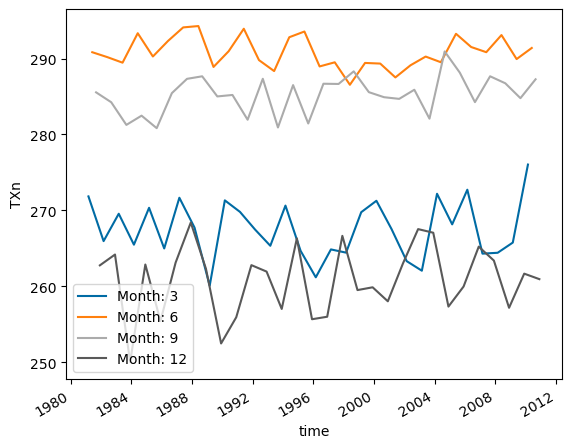

In [73]:
for state in ['Wisconsin']:# list(df_crop.State.unique()):
    state_coord = us_states[(us_states.NAME == state.title())]
    # Let's extract the state of interest and save as a separate dataset
    state_clim = climate.salem.subset(shape=state_coord)
    # Now let's take a spatial mean for entire state
    state_clim = state_clim.salem.roi(shape=
                state_coord).mean(dim=['lat','lon'])
    # Detrending all the features so that we can study the interannual affect of 
    # weather to crop yields.
    plot_month_group('TXn',12,1,2,3,4,5,6,7,8,9,10,11)

In [1120]:
# df_crop_srv.profile_report(explorative=True, html={'style': {'full_width': True}})

In [ ]:
# #Turkey
# #clim_loc = clim.where((clim.lat > 30) & (clim.lat < 50) & (clim.lon >20 ) & (clim.lon < 45), drop=True)
# #shdf = salem.read_shapefile(salem.get_demo_file('world_borders.shp'))
# #shdf = shdf.loc[shdf['CNTRY_NAME'] == 'Turkey']

# feature_cols = [ 'Rainfall' ,'Temperature','Usage amount']
# target_v = df['water level']
# X = df[feature_cols] 
# y = target_v 

# from sklearn.model_selection import TimeSeriesSplit
# tss = TimeSeriesSplit(n_splits = 3)
# for train_index, test_index in tss.split(X):
#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# mean = np.mean((df.values), axis=-1, keepdims=True)
# detrended = df - mean

# Modelling
<div class="span5 alert alert-info">
1. There are two main ways to predict the crop yield. The first one is from simple time series analysis of crop yield data, and building a time series model such as ARIMA. This method is straightforward, does not require any variable other than the yield itself and time as the single dimension. However, this method does not provide any physical inside for the problem and assumes that all the conditions relavent to crop production will be the same in the future. Despite the weakneses it can still provide a good starting point and can be useful to see how will the yield change in the future all the conditions stay the same as the past.

2. Second method would be building regression models to predict the crop yield from the actual physical parameters. This method is superior to time series analysis in terms of providing more actionable results, such as if we determine that the most important parameter is the rain amount during the growing season we could suggest irrigation to increase. 

We will use both of these methods and compare the results at the end
    </div>

## 1. ARIMA Model

In [206]:
# Impoting the libraries required for this section
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.metrics import mean_squared_error

<div class="span5 alert alert-warning">We will use corn, grain yield data to build an ARIMA model. For this purpose, we do not need the agro-climate indicators.
Let's remember how the corn data looks.
    </div>

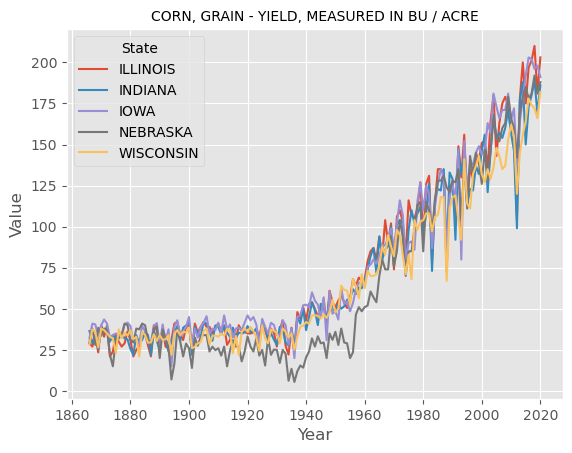

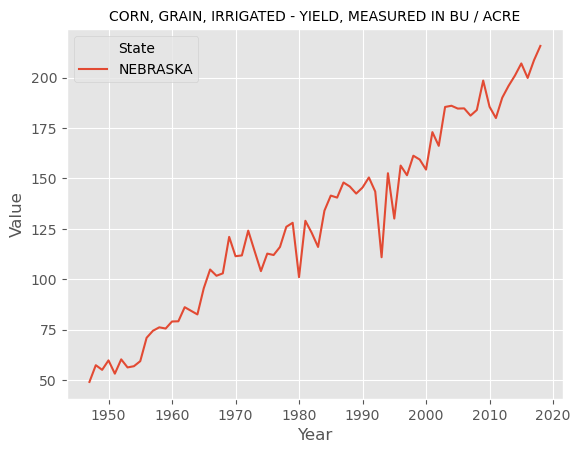

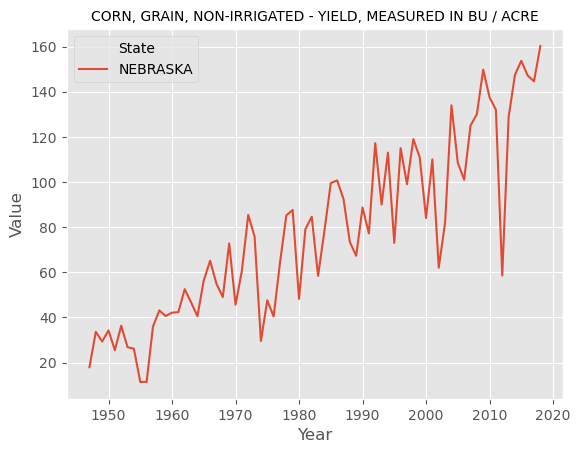

In [842]:
crop_trend_plot("CORN, GRAIN", 'YIELD')

Let's start with only 'ILLINOIS'.

In [844]:
# getting the only corn - yield rows
corn_mask = df_crop_srv['Data Item'] == \
    "CORN, GRAIN - YIELD, MEASURED IN BU / ACRE"
df_corn = df_crop_srv[corn_mask].reset_index(drop=True)
# creating dataframe for soybens in Illinois 
df_corn_il = df_corn[df_corn.State == 'ILLINOIS'].sort_values(by='Year').reset_index(drop=True)
df_corn_il.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Program     155 non-null    object 
 1   Year        155 non-null    int64  
 2   State       155 non-null    object 
 3   State ANSI  155 non-null    int64  
 4   Commodity   155 non-null    object 
 5   Data Item   155 non-null    object 
 6   Value       155 non-null    float64
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ KB


In [845]:
# Converting Year column to datetime object and setting as index
df_corn_il['Year'] = pd.to_datetime(df_corn_il['Year'], format='%Y')
df_corn_il.set_index('Year', inplace=True)

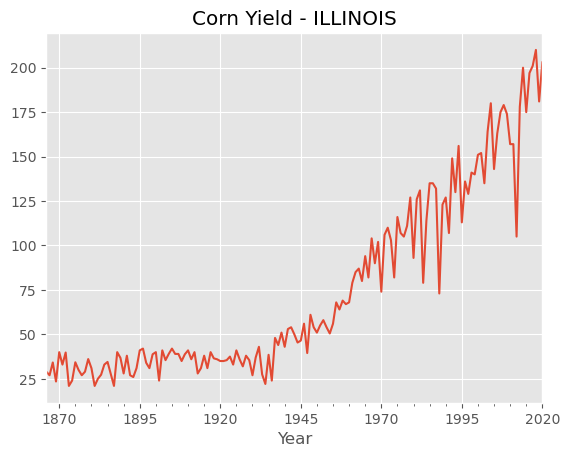

In [846]:
# Plotting corn yield for Illinois alone
# _ = df_corn_il['Value'].pct_change().plot(title="Corn Yield - ILLINOIS")
corn_yield = df_corn_il['Value']
_ = yield_soy.plot(title="Corn Yield - ILLINOIS")
# _ = df_corn_il.plot(x='Year', y='Value')

### Model Identification
Before we fit a model, we need to check if the data is stationary. There is abviously a strong trend starting from 1940s, but is it also a random walk? What does it take to make the model stationary?
* Test the null hypothesis that the model is random walk with Dicky-Fuller Test.
* Test the hypothesis that model is stationary with KPSS tests.
* Make the model stationary taking difference of the values.
* Plot the auto correlation function, and partial auto correlation function of the data to identify possible model order.
* Build multiple ARIMA models and with different orders and find the best one in terms of AIC and BIC scores

In [847]:
adf = adfuller(corn_yield)[1]
kpss_ = kpss(corn_yield, nlags="auto")[1]
print(f"Dickey-Fuller test p-value is {round(adf,3)}")
print(f"KPSS test p-value is {round(kpss_, 3)}")

Dickey-Fuller test p-value is 1.0
KPSS test p-value is 0.01


* Based on the Dickey-Fuller test we can not reject the null hypothesis which is the series has a unit root.
* The null hypothesis of the KPSS test is the opposite, which is the process is trend stationary. Since the p-value is smaller than 0.05 we can reject the null hypothesis in favor of the alternative. 

Thus both of the test suggest that the series is non-stationary. The easist way to get rid of the trend and make the data stationary is to take the lagged difference of the values. In most of the cases this will take care of non-stationarity. Let's try a differencing for a few lag.

The auto correlation plot tails off while the partial autocorrelation cuts off at lag 2. This suggest AR(2) model. However, we should check the acf and pacf plots after removing the trend in the next step. 

In [839]:
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# x= np.linspace(1, len(yield_soy), num=len(yield_soy) ).reshape(-1,1)
# model.fit(x, yield_soy)
# trend = model.predict(x)
# _ = plt.plot(yield_soy.values,label='Yield')
# _ = plt.plot(trend, label='trend')
# _ = plt.legend()
# _ = plt.title('The Linear Trend')

In [840]:
# # Now removing the trend from the data
# y = yield_soy.values - trend
# y = pd.Series(y, index=yield_soy.index)
# _ = plt.plot(y)

Let's see whether removing the trend helped to make the data stationary or not.

In [472]:
adf = adfuller(y)[1]
kpss_ = kpss(y, nlags="auto")[1]
print(f"Dickey-Fuller test p-value is {round(adf,4)}")
print(f"KPSS test p-value is {round(kpss_, 4)}")

Dickey-Fuller test p-value is 0.0
KPSS test p-value is 0.1


In [852]:
for i in range(4):
    if i == 0:
        y_diff = yield_soy
    elif i > 0:
        y_diff = yield_soy.diff(periods=i).dropna()
        
    print(f'p-value of randomness \
    for period={i} = {adfuller(y_diff)[1]}')
    
    print(f'p-value of stationarity \
    for period={i} = {kpss(y_diff, nlags="auto")[1]}')

p-value of randomness     for period=0 = 1.0
p-value of stationarity     for period=0 = 0.01
p-value of randomness     for period=1 = 5.638103990493574e-13
p-value of stationarity     for period=1 = 0.07191717120890298
p-value of randomness     for period=2 = 0.23180096594049643
p-value of stationarity     for period=2 = 0.07509765739198672
p-value of randomness     for period=3 = 0.21996923452184336
p-value of stationarity     for period=3 = 0.024790718129474934


#### Test Results
**Dickey-Fuller Test:** The first order differencing is sufficient with p-value << 0.05
**KPSS Test:** the first order difference is a weak stationary with p = 0.072. 
The succesive orders make it worse. This is probably because of the variance that is changing with time. Let's see the data after differencing.

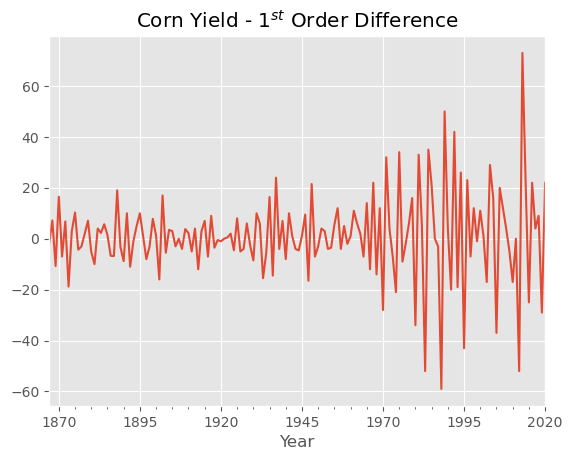

In [865]:
_ = yield_soy.diff().dropna().plot(title='Corn Yield - $1^{st}$ Order Difference')

Look's like the differencing took care of trend but the variance changes in time. The easiest way to make the variance constont is taking the log of the timeseries first

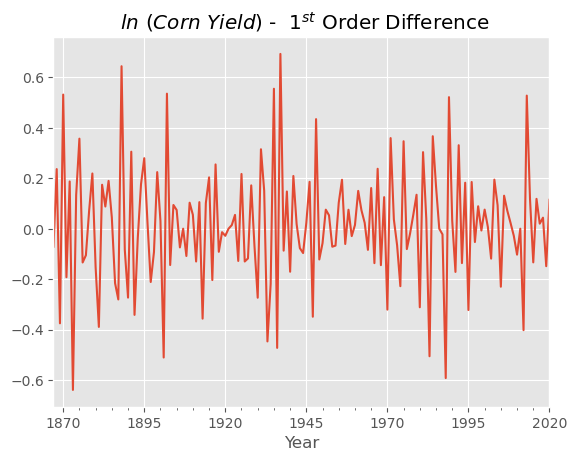

In [878]:
# Taking the first difference
ylog = np.log(yield_soy)
ylog_diff = ylog.diff().dropna()
# plotting y
_ = ylog_diff.plot(title = 
                   ' $ln {\ (Corn\ Yield)}$ -  $1^{st}$ Order Difference' )

In [880]:
# Let's make the stationarity tests again.
adf = adfuller(ylog_diff)[1]
kpss_ = kpss(ylog_diff, nlags="auto")[1]
print(f"Dickey-Fuller test p-value is {round(adf,4)}")
print(f"KPSS test p-value is {round(kpss_, 4)}")

Dickey-Fuller test p-value is 0.0
KPSS test p-value is 0.0417


This looks better in terms of variance and overall stationarity of the data. We will fit an ARIMA model now. Thus we actually do not need to take the difference but we should take the logarithm first.

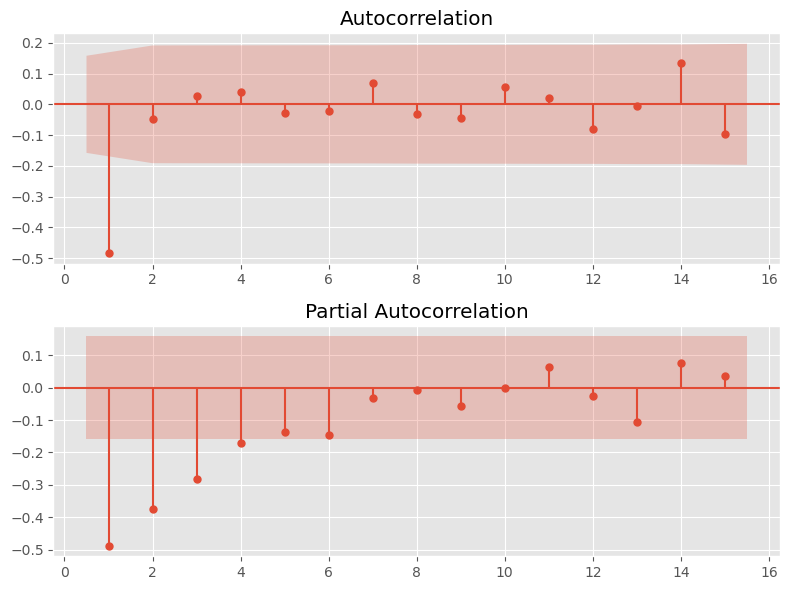

In [881]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6))

# Plot ACF and PACF
plot_acf(ylog_diff, lags=15, zero=False, ax=ax1)
plot_pacf(ylog_diff, lags=15, zero=False, ax=ax2)

# Show plot
plt.tight_layout()
plt.show()

* The auto correlation plot cuts off after the first lag 1.
* PACF tails off. 

<div class="span5 alert alert-info">
An ARIMA model with the order (0,1,1) might fit for the time series.

Recall the model choosing criteria based on ACF and PACF plots: </div>

<table><tbody><tr><th></th><th>AR(p)</th><th>MA(q)</th><th>ARMA(p,q)</th></tr><tr><td>ACF</td><td>Tails off</td><td>Cuts off after lag q</td><td>Tails off</td></tr><tr><td>PACF</td><td>Cuts off after lag p</td><td>Tails off</td><td>Tails off</td></tr></tbody></table>


### Model Selection
Three criteria will be used for model selection.
1. MSE error based on timestep-wise comparison between test data and one-step prediction ARIMA model.
2. Akaike information criteria
3. Bayesian information criteria

In [882]:
# Import mean_squared_error and ARIMA

# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split = int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [883]:
# Function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    score_dict = {'order':[], 'mse':[]}
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p, d, q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    score_dict['order'].append(order)
                    score_dict['mse'].append(mse)
                    print(f'ARIMA{order} MSE={round(mse, 4)}')
                except:
                    continue
    return pd.DataFrame(score_dict), print('Best ARIMA%s MSE=%.4f' % (best_cfg, best_score))

In [885]:
# Now, we choose a couple of values to try for each parameter.
# let's try up to 3 for each parameter
p_values = [i for i in range(3)] # from pacf plot the best p might be 3
d_values = [i for i in range(3)] # p-val of kpss lower but still close to 0.05. Let's try up to d=2
q_values = [i for i in range(3)] # Most likely we have model with MA order 0 since pacf plot cuts off

Now fitting corn_yield. Note that, this is the initial time series in which the differencing has not been done.

In [886]:
# Finally, we can find the optimum ARIMA model for our data.
import warnings
warnings.filterwarnings("ignore")
scores = evaluate_models(ylog, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=1.1916
ARIMA(0, 0, 1) MSE=0.4402
ARIMA(0, 0, 2) MSE=0.2538
ARIMA(0, 1, 0) MSE=0.0328
ARIMA(0, 1, 1) MSE=0.0194
ARIMA(0, 1, 2) MSE=0.0198
ARIMA(0, 2, 0) MSE=0.1069
ARIMA(0, 2, 1) MSE=0.0333
ARIMA(0, 2, 2) MSE=0.02
ARIMA(1, 0, 0) MSE=0.0406
ARIMA(1, 1, 0) MSE=0.0268
ARIMA(1, 1, 1) MSE=0.0197
ARIMA(1, 1, 2) MSE=0.0201
ARIMA(1, 2, 0) MSE=0.0613
ARIMA(2, 0, 0) MSE=0.0308
ARIMA(2, 1, 0) MSE=0.0229
ARIMA(2, 1, 1) MSE=0.0202
ARIMA(2, 1, 2) MSE=0.0212
ARIMA(2, 2, 0) MSE=0.0418
ARIMA(3, 0, 0) MSE=0.0262
ARIMA(3, 1, 0) MSE=0.0236
ARIMA(3, 1, 1) MSE=0.0211
ARIMA(3, 1, 2) MSE=0.021
ARIMA(3, 2, 0) MSE=0.0394
Best ARIMA(0, 1, 1) MSE=0.0194


The best ARIMA model based on MSE is ARIMA(0,1,1). Let's compare the models based on AIC and BIC scores to be more confident about our final model.

In [890]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(3):
  # Loop over d values from 0-2
    for d in range(3):    
    # Loop over q values from 0-2
        for q in range(3):
            # create and fit ARIMA(p,d,q) model
            try:
                model = ARIMA(ylog, order=(p, d, q))
                results = model.fit(disp=0)

                # Append order and results tuple
                order_aic_bic.append((p, d, q, results.aic, results.bic))
            except:
                continue

In [1051]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'd', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
order_df.sort_values('AIC').reset_index(drop=True).head()

,p,d,q,AIC,BIC
0,0,1,1,-85.493706,-76.382849
1,0,1,2,-84.150311,-72.002501
2,1,1,1,-83.999952,-71.852142
3,2,1,1,-83.461205,-68.276442
4,1,1,2,-82.034217,-66.849454


In [1052]:
# Print order_df in order of increasing BIC
order_df.sort_values('BIC').reset_index(drop=True).head()

,p,d,q,AIC,BIC
0,0,1,1,-85.493706,-76.382849
1,0,1,2,-84.150311,-72.002501
2,1,1,1,-83.999952,-71.852142
3,2,1,1,-83.461205,-68.276442
4,1,1,2,-82.034217,-66.849454


All three criteria, (BIC, AIC and MSE) point to same model: ARIMA(0,1,1), just like we anticipated from the ACF and PACF plots.

All three criteria, (BIC, AIC and MSE) points to same model: ARIMA(0,1,1), just like we anticipated from the ACF and PACF plots. 

* The best model based on BIC is: ARIMA(0,1,1)
* The best model based on AIC ARIMA(2, 1, 2), but ARIMA(0, 1, 1) score is very close to best score
* The Best models based on the MSE are ARIMA(2,1,2), but ARIMA(0,1,1) is the simplest model with one of the lowest score
Since the ARIMA(0,1,1) is a much simplier model than ARIMA(2,1,2) and still performance almost as well as the best model based on AIC and MSE criteria, I will fit the series with ARIMA(0,1,1)

In [1070]:
arima = ARIMA(ylog,order=(0,1,1))
model = arima.fit()
forecast = model.forecast(25)
y_pred = model.predict()

In [1025]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Value   No. Observations:                  154
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  45.747
Method:                       css-mle   S.D. of innovations              0.179
Date:                Tue, 09 Mar 2021   AIC                            -85.494
Time:                        17:53:24   BIC                            -76.383
Sample:                    01-01-1867   HQIC                           -81.793
                         - 01-01-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0126      0.003      3.963      0.000       0.006       0.019
ma.L1.D.Value    -0.7860      0.043    -18.233      0.000      -0.871      -0.702
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.2722           +0.0000j            1.2722            0.0000
-----------------------------------------------------------------------------
"""

<p>Here is a reminder of the tests in the model summary:</p>

<table>
  <tbody><tr>
    <th>Test</th>
    <th>Null hypothesis</th>
    <th>P-value name</th>
  </tr>
  <tr>
    <td>Ljung-Box</td>
    <td>There are no correlations in the residual<br></td>
    <td>Prob(Q)</td>
  </tr>
  <tr>
    <td>Jarque-Bera</td>
    <td>The residuals are normally distributed</td>
    <td>Prob(JB)</td>
  </tr>
</tbody></table>

PRob(Q) = 0.13 > 0.05. We should reject the null hypothesis and deduce that there are correlations in the residuals. Moreover, Prob(JB) < 0.05 i.e. residuals not normally distribute based on the Jarque-Bera test. 

### Model Diagnostics

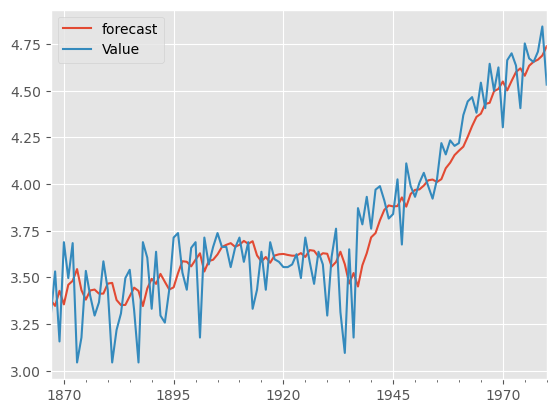

In [1037]:
_ = fitted.plot_predict()

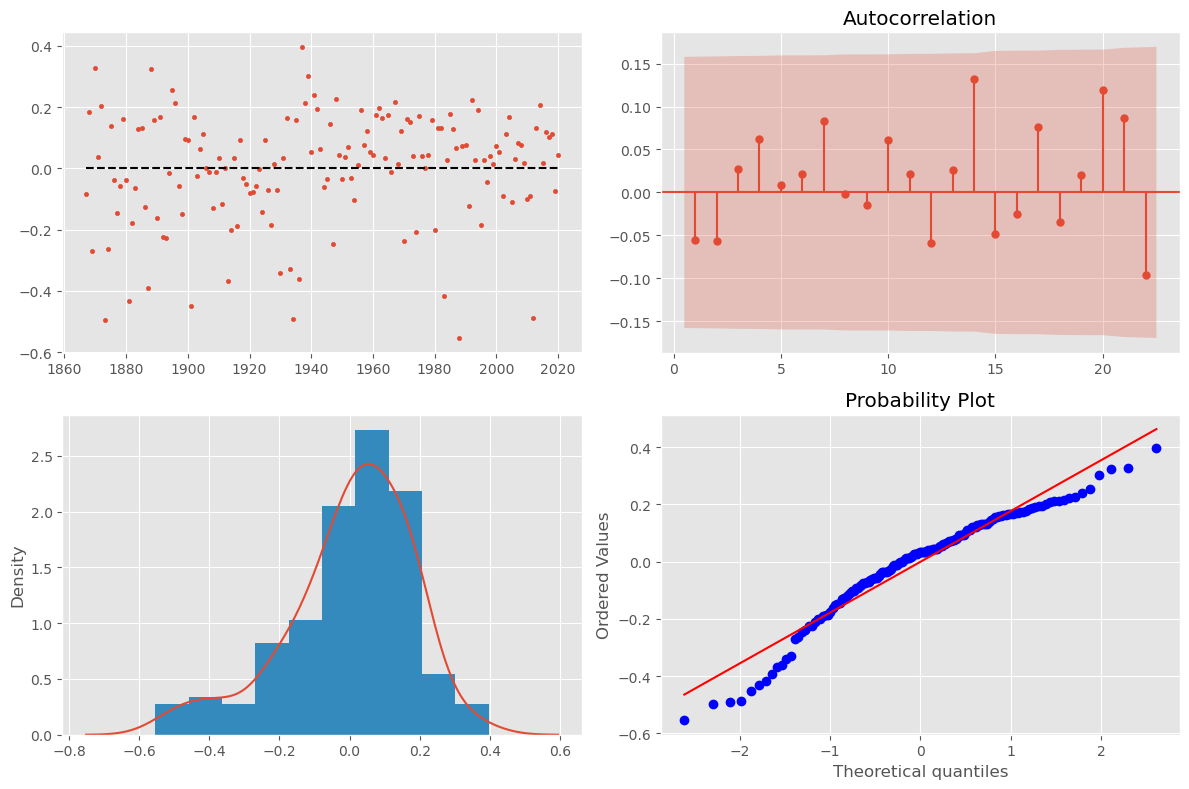

In [1026]:
import statsmodels.api as sm
import scipy.stats as stats
# Plot residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(2,2,figsize=(12,8))
# residuals.plot.scatter(x=residuals.index, y=residuals.values, title="Residuals", ax=ax[0], linestyle=None, marker='.')
ax[0,0].scatter(x=residuals.index, y=residuals.values, marker='.')
ax[0,0].plot(residuals.index, np.zeros(len(residuals)), 'k--')
plot_acf(residuals, ax=ax[0,1], zero=False)
# residuals.plot(kind='kde', title='Density', ax=ax[1,0])
sns.kdeplot(residuals.values.reshape(-1,), ax=ax[1,0])
ax[1,0].hist(residuals,density=True)
# sm.qqplot(residuals, line='45',ax=ax[1,1])
stats.probplot(residuals.values.reshape(-1,), dist="norm", plot=plt)
plt.tight_layout()
plt.show()

In [1027]:
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("Data follows Normal Distribution")
else:
    print("Data does not follow Normal Distribution")

stat=0.948, p=0.000
Data does not follow Normal Distribution


In [1028]:
from scipy.stats import anderson
result = anderson(residuals.values.reshape(-1,))
print('stat=%.3f' % (result.statistic))
for i in range(len(result.critical_values)):
 sl, cv = result.significance_level[i], result.critical_values[i]
 if result.statistic < cv:
  print('Data follows Normal at the %.1f%% level' % (sl))
 else:
  print('Data does not follows Normal at the %.1f%% level' % (sl))

stat=2.389
Data does not follows Normal at the 15.0% level
Data does not follows Normal at the 10.0% level
Data does not follows Normal at the 5.0% level
Data does not follows Normal at the 2.5% level
Data does not follows Normal at the 1.0% level


<div class="span5 alert alert-warning">
Model have some outliers, the residuals are not normally distributed. The only good news is, there is no correlation in the residuals.
    </div>

Let's see the model with the un-modified yield data, plus with a dynamic forecast.

In [1113]:
# Create Training and Test
train = ylog[:119]
test = ylog[119:]
print(f'Test percent: {100*round(len(test)/len(train), 2)}')

Test percent: 30.0


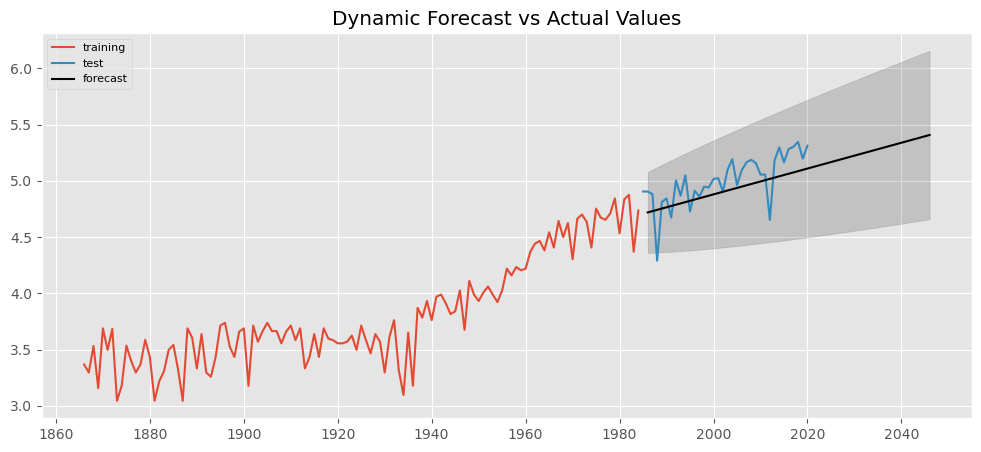

In [1114]:
# Build Model
# model = ARIMA(train, order=(3,2,1))    
def plot_dynamic_pred(dt, dtrain, dtest, order):
    model = ARIMA(dtrain, order=order)  
    fitted = model.fit(disp=-1)  
    ypred = model.predict(dtrain, dynamic=True)
    ypred = pd.Series(ypred,index=dtrain.index[order[1]:])
    forecast_period= len(test)+25
    # Forecast
    fc, se, conf = fitted.forecast(forecast_period, alpha=0.05)  # 95% conf

    # Make as pandas series

    date_range = pd.date_range(dt.index[-len(test)], periods = forecast_period, 
                  freq='Y').strftime("%Y-%m-%d").tolist()
    date_range = pd.to_datetime(date_range)

    fc_series = pd.Series(fc, index=date_range)
    lower_series = pd.Series(conf[:, 0], index=date_range)
    upper_series = pd.Series(conf[:, 1], index=date_range)

    # Plot
    _=plt.figure(figsize=(12,5), dpi=100)
    _ = plt.plot(dtrain, label='training')
    # _ = fitted.plot_predict()
    _= plt.plot(dtest, label='test')
    _= plt.plot(fc_series, label='forecast', c='k')
    _= plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)

    _=plt.title('Dynamic Forecast vs Actual Values')
    _=plt.legend(loc='upper left', fontsize=8)
    # plt.show()
plot_dynamic_pred(ylog,train, test, (0,1,1))

<div class="span5 alert alert-info">
    Finally let's try the original data without taking logarithm as we did before to fix the variance change in time. In the previous model, we had a trouble finding the best model order. We chose ARIMA(0,1,1), but the residuals were not normal. Whereas any more complicated models actually make worse of both the normallity of the residuals and other criteria like mse. </div>

This time let's use sklearns' SARIMAX method, which is equivalent its ARIMA model but have some more features.

In [1047]:
# Let's test mse for ARIMA models with original data
y = corn_yield
import warnings
warnings.filterwarnings("ignore")
scores = evaluate_models(y, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=9615.9986
ARIMA(0, 0, 1) MSE=3814.3213
ARIMA(0, 0, 2) MSE=2393.8957
ARIMA(0, 1, 0) MSE=664.856
ARIMA(0, 1, 1) MSE=445.5112
ARIMA(0, 1, 2) MSE=474.7983
ARIMA(0, 2, 0) MSE=2019.2597
ARIMA(0, 2, 1) MSE=671.8811
ARIMA(0, 2, 2) MSE=414.0456
ARIMA(1, 0, 0) MSE=703.9782
ARIMA(1, 1, 0) MSE=561.4672
ARIMA(1, 2, 0) MSE=1204.8582
ARIMA(2, 0, 0) MSE=592.6086
ARIMA(2, 1, 0) MSE=507.1121
ARIMA(2, 1, 1) MSE=489.4671
ARIMA(2, 1, 2) MSE=479.8809
ARIMA(2, 2, 0) MSE=885.4417
ARIMA(3, 0, 0) MSE=536.8334
ARIMA(3, 1, 0) MSE=534.5767
ARIMA(3, 1, 1) MSE=520.1938
ARIMA(3, 2, 0) MSE=809.0811
Best ARIMA(0, 2, 2) MSE=414.0456


In [1055]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(3):
  # Loop over d values from 0-2
    for d in range(3):    
    # Loop over q values from 0-2
        for q in range(3):
            # create and fit ARIMA(p,d,q) model
            try:
                model = ARIMA(y, order=(p, d, q))
                results = model.fit(disp=0)

                # Append order and results tuple
                order_aic_bic.append((p, d, q, results.aic, results.bic))
            except:
                continue

In [1056]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'd', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
order_df.sort_values('AIC').reset_index(drop=True).head()

,p,d,q,AIC,BIC
0,0,2,2,1228.378489,1240.500241
1,1,1,2,1236.844741,1252.029504
2,0,1,1,1241.968882,1251.079740
3,0,1,2,1243.420558,1255.568368
4,1,1,1,1243.539276,1255.687086


In [1057]:
order_df.sort_values('BIC').reset_index(drop=True).head()

,p,d,q,AIC,BIC
0,0,2,2,1228.378489,1240.500241
1,0,1,1,1241.968882,1251.079740
2,1,1,2,1236.844741,1252.029504
3,0,1,2,1243.420558,1255.568368
4,1,1,1,1243.539276,1255.687086


All three criteria we used point to same model, again, but this time the order of the best model is (0,2,2)

In [1098]:
# Calling SARIMAX and fitting to original data
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 2, 2))

results = mod.fit()

# one-step ahead prediction
pred = results.get_prediction(start=pd.to_datetime('1870-01-01'), dynamic=False)
pred_ci = pred.conf_int()

# Dynamic Prediction
pred_dynamic = results.get_prediction(start=pd.to_datetime('1945-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_uc_ci = pred_uc.conf_int()

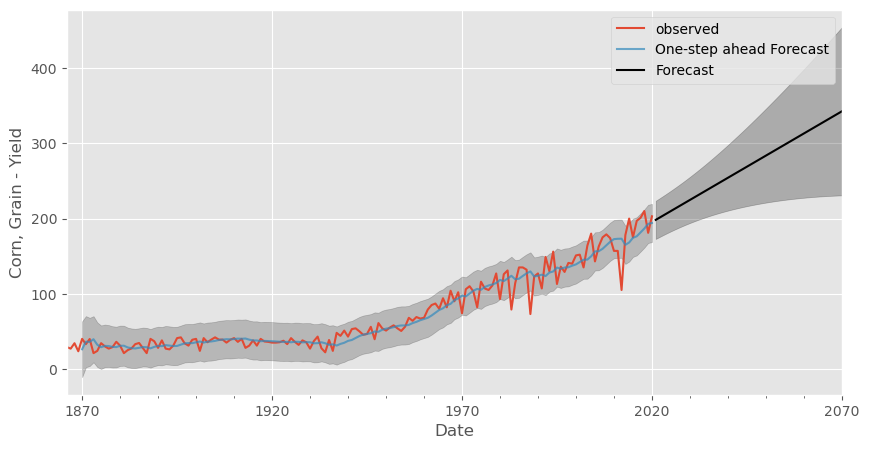

In [1107]:
fig, ax = plt.subplots(figsize=(10,5))
ax = corn_yield.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', c='k')
ax.fill_between(pred_uc_ci.index,
                pred_uc_ci.iloc[:, 0],
                pred_uc_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Corn, Grain - Yield')
plt.legend()

plt.show()
 


#### Plot Dynamic prediction

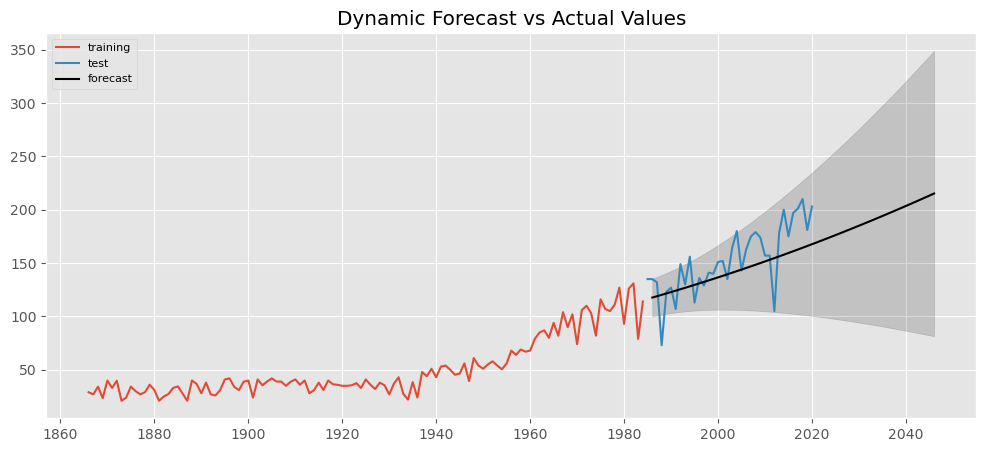

In [1115]:
# Create Training and Test and plot dynamic prediction
train = y[:119]
test = y[119:]
plot_dynamic_pred(y,train, test, (0,2,2))

### Conclusion For ARIMA Models

<div class="span5 alert alert-info">
    Arima models for the corn, grain production for ILLINOIS, can be considered as having limited prediction capability. I tried two models, one with the original data and the other one with the natural logarithm of the actual values to make the data more stationary by cancelling the temporal variance change. However, both of the model has suffered from non-normal residual distriution at the end. Both of the model have residuals without autocorrelation at any lag. 
    
Overall, I would not suggest using ARIMA model for corn, grain yield. Although here I showed analysis for ILLINOIS, I made the same analysis for a few other states, none of which showed any promises for an ARMA model. Also not shown here is the soy bean yields, which have very similar results. 

Perhaps,the better way to model crop yield would be using the agro-climatic indicators as features and building a regression model. In the next chapter I will do this. However, this time the major limitation is the lack of sufficiently long time series data for agro-climatic indicators, which starts at 1980s. The major challenge would be cross-validation and testing the model.
    </div>

# Brainstorming
* Trytaking first difference using the pandas method .diff() to remove the drift instead of detrending by linear regression.
